In [1]:
import sys
sys.path.append("/home/tinkerer/spin-qubit/codes/")
sys.path.insert(0, "/home/tinkerer/Poisson_Solver")

import kwant
import numpy as np
from scipy import constants
import itertools as it
import scipy.sparse.linalg as sla
from dask_quantumtinkerer import Cluster, cluster_options
import dask.bag as db

from potential import gate_potential, linear_problem_instance
from ccode.gates_trijunction import triangular_gates_2
from ccode.finite_system import finite_system
from ccode.solvers import junction_parameters, phase, bands, finite_coupling_parameters, sort_eigen
from ccode.tools import get_potential
from ccode.plotting import plot_gates

import matplotlib.pyplot as plt
from utility import prepare_voltages
from plotting import plot_potential
from layout import (
    Layout,
    OverlappingGateLayer,
    PlanarGateLayer,
    SimpleChargeLayer,
    SimpleVoltageLayer,
    TwoDEGLayer,
)
from Hamiltonian import discrete_system_coordinates, kwant_system, tight_binding_Hamiltonian


import matplotlib as mpl
mpl.rcParams.update({'font.size': 16})

/opt/conda/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [2]:
options = cluster_options()
options.worker_cores = 1
options.worker_memory = 8
options.extra_path = "/home/jtorresluna/trijunction_design/"

In [7]:
mu = bands[0]
# Set up system paramters
thickness_barrier = 4
thickness_twoDEG = 4
thickness_gates = 6
thickness_self_Al2O3 = 4

meff = 0.023 * constants.m_e  # in Kg
eV = 1.0
bandgap_GaAs = 1.519 * eV

permittivity_metal = 5000
permittivity_GaAs = 12.18
permittivity_twoDEG = 15  # InAs
permittivity_air = 1.0
permittivity_Al2O3 = 9.1

grid_spacing_twoDEG = 1
grid_spacing_normal = 1
grid_spacing_dielectric = 5
grid_spacing_air = 5
grid_spacing_GaAs = grid_spacing_normal
grid_spacing_gate = grid_spacing_twoDEG
grid_spacing = grid_spacing_twoDEG

# geometrical parameters
area = 1200
angle = 0.125*np.pi
wire_width = 7
gap = 4

triangle_length = np.sqrt(area*np.tan(angle))
triangle_width = np.abs((triangle_length/np.tan(angle)))
top_shift = np.tan(angle)*(wire_width/2)
tunnel_length = 3
tunnel_width = wire_width

total_length = triangle_length + 2 * tunnel_length + 2 * gap - top_shift
extra_width = 10
total_width = 2 * extra_width + triangle_width
total_width = 2*total_width

# Set up gates
gates = triangular_gates_2(area, angle, wire_width, tunnel_length, gap, extra_width)

# Boundaries within Poisson region
zmin = -0.5
zmax = 0.5
xmax = triangle_width
xmin = -xmax
ymin = 0
ymax = total_length
boundaries = [xmin, xmax, ymin, ymax, zmin, zmax]

a = 1
L = boundaries[3] - boundaries[2]
W = boundaries[1] - boundaries[0]

# Solve for Poisson system
layout = Layout(total_width,
                total_length,
                grid_width_air=grid_spacing_air,
                margin=(50, 50, 50),
                shift=(0, total_length/2, 0))

layout.add_layer(
    TwoDEGLayer(
        "twoDEG",
        thickness_twoDEG,
        permittivity_twoDEG,
        grid_spacing_twoDEG
    ),
    center=True,
)

layout.add_layer(
    SimpleChargeLayer(
        "GaAs",
        thickness_barrier,
        permittivity_Al2O3,
        grid_spacing_GaAs,
    )
)

vertex = (
    list(gates["plunger_gates"].values()),
    list(gates["screen_gates"].values()),
    list(gates["tunel_gates"].values()),
        )

layout.add_layer(
    OverlappingGateLayer(
        vertex,
        np.hstack([list(gates[key].keys()) for key, _ in gates.items()]),
        thickness_gates,
        thickness_self_Al2O3,
        permittivity_metal,
        grid_spacing_gate,
    )
)

poisson_system = layout.build()
linear_problem = linear_problem_instance(poisson_system)


site_coords, site_indices = discrete_system_coordinates(
    poisson_system, [('mixed', 'twoDEG')], boundaries=boundaries
)

crds = site_coords[:, [0, 1]]
offset = crds[0]%grid_spacing

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


In [8]:
# Build kwant system
a = 10e-9
center = W*a/4
centers = [center, -center]
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'down',
    "shape": 'rectangle',
    "L": L*a,
    "W": W*a,
    "centers": centers
}

# tunnel positions
x_r, y_r = int(W/4)*a, 0
x_l, y_l = -int(W/4)*a, 0
x_c, y_c = 0, 0

# create kwant system
trijunction, f_params, f_params_potential = finite_system(**geometry)
trijunction = trijunction.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [9]:
# Functions used for adaptive calculations
def potential(voltage_setup, offset=offset, grid_spacing=1):
    charges = {}
    clean_potential = gate_potential(
        poisson_system,
        linear_problem,
        site_coords[:, [0, 1]],
        site_indices,
        voltage_setup,
        charges,
        offset,
        grid_spacing
    )
    return clean_potential

def get_hamiltonian(voltage_setup, key_1, val_1, key_2, val_2, params, points):
    voltage_setup[key_1] = val_1
    voltage_setup[key_2] = val_2    
    f_pot = get_potential(potential(voltage_setup=voltage_setup, grid_spacing=10e-9))

    ham_mat = trijunction.hamiltonian_submatrix(sparse=True,
                                                params=f_params_potential(potential=f_pot,
                                                                          params=params))
    
    return ham_mat, potential_at_gates(f_pot, points)

def potential_at_gates(f_pot, points):
    data = []
    for point in points:
        x, y = point
        data.append(f_pot(x, y))
    return np.array(data)

def solver_electrostatics(tj_system, voltage_setup, key, n, eigenvecs):
    """
    
    """
    params = junction_parameters(m_nw=np.array([mu, mu, mu]), m_qd=0)

    def eigensystem_sla(val, extra_params):
        
        params.update(extra_params)
        system, f_params_potential = tj_system

        voltage_setup[key] = val
        f_potential = get_potential(potential(voltage_setup=voltage_setup, grid_spacing=10e-9))
        f_params = f_params_potential(potential=f_potential, params=params)
        ham_mat = system.hamiltonian_submatrix(sparse=True, params=f_params)

        if eigenvecs:
            evals, evecs = sort_eigen(sla.eigsh(ham_mat.tocsc(), k=n, sigma=0))
        else:
            evals = np.sort(sla.eigsh(ham_mat.tocsc(), k=n, sigma=0, return_eigenvectors=eigenvecs))
            evecs = []

        return evals, evecs

    return eigensystem_sla 

In [10]:
def get_voltage_setup_LR():

    depleted = -0.015

    screen_voltages = {
        'left_screen_triangle': 1.2*depleted,
        'right_screen_triangle': 1.2*depleted,
        'central_screen_gate': depleted,
        'left_screen_side': depleted,
        'right_screen_side': depleted,
        'left_screen': depleted,
        'right_screen': depleted
    }

    tunel_voltages = {
        'top_tunel': -0.01,#0.095,
        'left_tunel': 0.022,#-0.07,
        'right_tunel': 0.022 #0.1
    }

    plunger_voltages = {'plunger_gate': 0.003}

    voltage_setup_LR = dict()
    voltage_setup_LR.update(screen_voltages)
    voltage_setup_LR.update(tunel_voltages)
    voltage_setup_LR.update(plunger_voltages)

    volt = list(voltage_setup_LR.values())
    gates = list(voltage_setup_LR.keys())
    voltage_setup_LR = prepare_voltages(volt, gates)

    return voltage_setup_LR

def plot_potential(potential=[], cut=[0.0], cmap="gist_heat_r", scale=1, **kwargs):

    total_potential = []
    for element in potential:
        coordinates = np.array(list(element.keys()))
        values = np.array(list(element.values()))
        total_potential.append(values)

    x = scale*coordinates[:, 0]
    y = scale*coordinates[:, 1]
    width = np.unique(x).shape[0]
    X = x.reshape(width, -1)
    Y = y.reshape(width, -1)
    Z = sum(total_potential).reshape(width, -1)

    fig = plt.figure(figsize=(13, 5))
    ax1 = fig.add_subplot()
    cont = ax1.contour(X, Y, Z, cmap=cmap, levels=100, **kwargs)
    cbar1 = fig.colorbar(cont, ax=ax1, format="%.4f")
    ax1.set_xlabel("X [nm]")
    ax1.set_ylabel("Y [nm]")


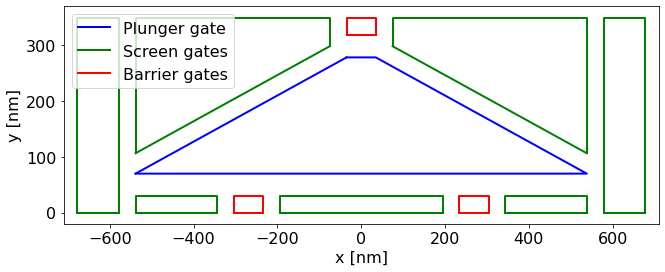

In [17]:
ratio = 16/6
plot_gates(gates, ylims=(-20, 370), xlims=(-710, 710), figsize=(4*ratio, 4), address='gates_1.pdf');

In [87]:
voltage_setup = get_voltage_setup_LR()

clean_potential = potential(voltage_setup=voltage_setup)
clean_potential.update(
    (key, -1 * value) for key, value in clean_potential.items()
)

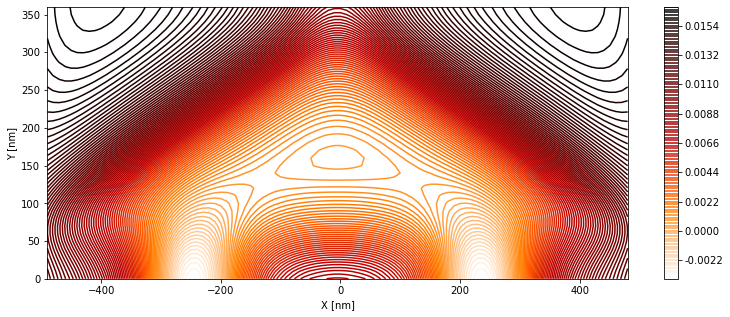

In [88]:
plot_potential([clean_potential], [0.0, 10.0, 20.0, 30.0], scale=10)

(-1e-07, 4.4e-07)

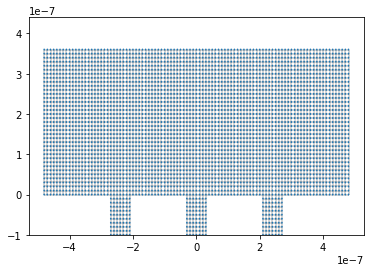

In [89]:
fig, ax = plt.subplots()
kwant.plot(trijunction, ax=ax);
ax.set_ylim(-1e-7, 4.4e-7)

In [90]:
solver = solver_electrostatics(tj_system=[trijunction, f_params_potential],
                               voltage_setup=get_voltage_setup_LR(),
                               key='plunger_gate',
                               n=40, 
                               eigenvecs=True)

In [91]:
plunger = 7.5e-3

phis = np.linspace(0, 2*np.pi, 25)
phases_params = []

for phi in phis:
    phases_params.append(finite_coupling_parameters(index=0,phis=[phi, 0, 0])[0])

args = list(it.product([plunger], phases_params))
args_db = db.from_sequence(args, npartitions=20)

In [92]:
def wrapper(arg):
    return solver(*arg)

In [93]:
%%time

evals = []
evecs = []

for arg in args:
    ev, evc = wrapper(arg)
    evals.append(ev)
    evecs.append(evc)

CPU times: user 1min 54s, sys: 2.2 s, total: 1min 57s
Wall time: 1min 57s


In [94]:
evals = np.array(evals)

In [95]:
phi_max_13 = phis[np.argmax(evals.T[21])]

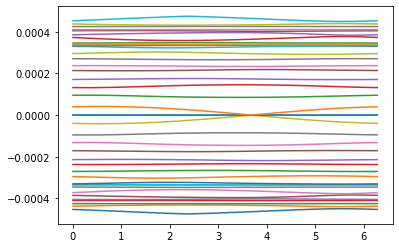

In [96]:
for level in evals.T:
    plt.plot(phis, level)

In [97]:
phi_max_13

0.5235987755982988

In [98]:
plungers = np.linspace(4e-3, 8.5e-3, 50)
args = list(it.product(plungers, [finite_coupling_parameters(index=0,phis=[phi_max_13, 0, 0])[0]]))

In [99]:
%%time

plunger_evals = []
plunger_evecs = []

for arg in args:
    ev, evc = wrapper(arg)
    plunger_evals.append(ev)
    plunger_evecs.append(evc)

CPU times: user 4min 7s, sys: 5.23 s, total: 4min 12s
Wall time: 4min 12s


In [100]:
plunger_evals = np.array(plunger_evals)

(-0.0003, 0.0003)

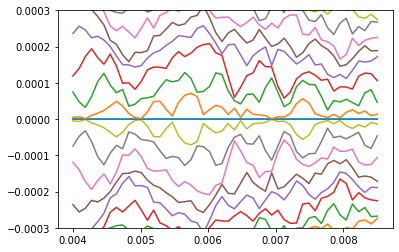

In [101]:
for level in plunger_evals.T:
    plt.plot(plungers, level)
plt.ylim(-3e-4, 3e-4)

In [103]:
density = kwant.operator.Density(trijunction, np.eye(4))

/tmp/ipykernel_41607/838840262.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(trijunction, density(plunger_evecs[20][22]), ax=ax)


(-4.5e-07, 4.5e-07)

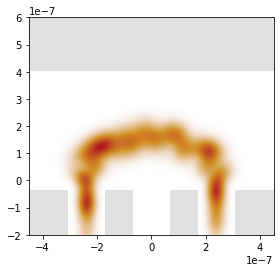

In [105]:
fig, ax = plt.subplots()
kwant.plotter.density(trijunction, density(plunger_evecs[20][22]), ax=ax)
ax.set_ylim(-2e-7, 6e-7)
ax.set_xlim(-4.5e-7, 4.5e-7)